# Algebra in Theano

#### Table of contents
- __[Baby Steps](#baby_steps)__: Adding
- __[Advanced](#advanced)__: Derivatives

In [20]:
import numpy as np
import theano.tensor as T
from theano import function

## Baby Steps <a id='baby_steps'></a>
Notes based on http://deeplearning.net/software/theano/tutorial/adding.html.

### Adding two scalars
First, something simple: adding two numbers. To do so, we define two variables that we want to add. In theano, all variables are typed. __dscalar__ is the type of a double scalar. Calling __dscalar__ with a string argument creates a named variable for a float scalar (the name is optional).

In [21]:
x = T.dscalar('x')
y = T.dscalar('y')

Note: __dscalar__ is not a class. $x$ and $y$ are instances of __TensorVariable__. They are assigned the type __dscalar__, however.

In [22]:
x.type is T.dscalar

True

Combining $x$ and $y$ produces a variable $z$ which represents the addition of $x$ and $y$.

In [23]:
z = x + y

Finally, we create a function that takes $x$ and $y$ as inputs and returns $z$:

In [24]:
f = function([x, y], z)

The first argument is a list of variables provided as inputs, while the second argument can be a single variable _or_ a list. The function can be called like this:

In [25]:
f(2, 3)

array(5.0)

Note: There's also __z.eval()__, which can be passed a dictionary mapping $x$ and $y$ to values. It doesn't need to import __function()__, but is otherwise less flexible.
### Adding two matrices
Now, instead of instantiating $x$ and $y$ as scalars, we create them as matrix types and create another function $f$ to add them.

In [26]:
x = T.dmatrix('x')
y = T.dmatrix('y')
z = x + y
f = function([x, y], z)

We can now use it to sum up matrices, i.e. 2d arrays (1d arrays are vectors). Note: They need to have the same dimensions, naturally.

In [27]:
f([[1, 2], [3, 4]], [[5, 6], [7, 8]])

array([[  6.,   8.],
       [ 10.,  12.]])

Numpy arrays can also be used directly as inputs.

In [28]:
f(np.array([[1, 2], [3, 4]]), np.array([[5, 6], [7, 8]]))

array([[  6.,   8.],
       [ 10.,  12.]])

### Exercise
Computation of $a^2 + b^2 + 2 a b$:

In [29]:
a = T.vector()
b = T.vector()
out = a ** 2 + b ** + 2 * a * b
f = function([a, b], out)
f([1, 2], [3, 4])

array([  28.,  132.])

## Advanced <a id='advanced'></a>
Notes based on: http://deeplearning.net/software/theano/tutorial/gradients.html.

### Computing Gradients
To compute a gradient in Theano, we use __T.grad__. Note that the first argument of __T.grad__ has to be a scalar. Here is the code to compute the gradient of $x^2$:

In [30]:
from theano import pp
x = T.dscalar('x')
y = x ** 2
gy = T.grad(y, x)
pp(gy)

'((fill((x ** TensorConstant{2}), TensorConstant{1.0}) * TensorConstant{2}) * (x ** (TensorConstant{2} - TensorConstant{1})))'

We can check with __pp__ if we computed the gradient correctly. Note that __fill((x ** 2), 1.0)__ means to make a matrix of the same shape as $x^2$ and fill it with 1.0.

Computing and plotting the gradient of the logistic function, $\frac{\partial s}{\partial x} = s(x) \cdot (1 - s(x))$, looks like this:

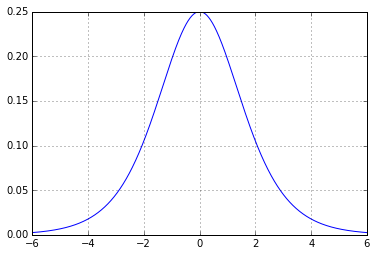

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
x = T.dscalar()
s = 1 / (1 + T.exp(-x))
gs = T.grad(s, x)
logistic = function([x], gs)
plt.grid()
values = np.arange(-6, 6, 0.01)
plt.plot(values, [logistic(i) for i in values])

Note that in order to compute the gradient of the logistic function of a matrix, x has to be specified as a matrix and the sigmoid needs to be:

In [38]:
s = T.sum(1 / (1 + T.exp(-x)))

### Computing the Jacobian
The Jacobian matrix is a matrix comprising the first partial derivatives of the output of a function wrt its inputs. The Jacobian is the tensor generalizing this notion. It's computed using __gradient.jacobian__ similarly to the gradient, by first specifying the expression and then wrt what the jacobian should be computed.

In [47]:
from theano import gradient
x = T.dvector('x')
y = x ** 2
Jy = gradient.jacobian(y, x)
f = function([x], Jy)
f([1, 2, 3])

array([[ 2.,  0.,  0.],
       [ 0.,  4.,  0.],
       [ 0.,  0.,  6.]])

We can also compute the Jacobian manually using __scan__ by looping over the entries in $y$ and computing the gradient of $y_i$ with respect to $x$. We do this by generating a sequence of integers from 0 to __y.shape[0]__ using __T.arange__ and loop through this sequence.

In [62]:
from theano import scan
x = T.dvector('x')
y = x ** 2
J, updates = scan(lambda i, y, x: T.grad(y[i], x), sequences=T.arange(y.shape[0]), non_sequences=[y, x])
f = function([x], J, updates=updates)
f([4, 4])

array([[ 8.,  0.],
       [ 0.,  8.]])

### Computing the Hessian
The Hessian is the matrix comprising the second order partial derivatives of a function with scalar output and vector input.

In [80]:
x = T.dvector('x')
y = x ** 2
cost = y.sum()
Hy = gradient.hessian(cost, x)
f = function([x], Hy)
f([0, 1, 2])

array([[ 2.,  0.,  0.],
       [ 0.,  2.,  0.],
       [ 0.,  0.,  2.]])

As before, the Hessian can also be computed manually, with the only difference beign that instead of computing the Jacobian of some expression $y$, we compute the gradient of the gradient of a scalar cost wrt $x$.

In [83]:
x = T.dvector('x')
y = x ** 2
cost = y.sum()
gy = T.grad(cost, x)
H, updates = scan(lambda i, gy, x: T.grad(gy[i], x), sequences=T.arange(gy.shape[0]), non_sequences=[gy, x])
f = function([x], H, updates=updates)
f([4, 4])

array([[ 2.,  0.],
       [ 0.,  2.]])

### Jacobian times a Vector
There are special functions to enable faster computation of a Jacobian times a vector.

#### R-operator
The _R operator_ evaluates the product between a Jacobian and a vector, i.e. $\frac{\partial f(x)}{\partial x} v$.

In [89]:
W = T.dmatrix('W')
V = T.dmatrix('V')
x = T.dvector('x')
y = T.dot(x, W)
JV = T.Rop(y, W, V)
f = function([W, V, x], JV)
f([[1, 1], [1, 1]], [[2, 2], [2, 2]], [0, 1])

array([ 2.,  2.])

#### L-operator
Similarly, the _L-operator_ computes a _row_ vector times a Jacobian, i.e. $v \frac{\partial f(x)}{\partial x}$.

In [91]:
W = T.dmatrix('W')
v = T.dvector('v')
x = T.dvector('x')
y = T.dot(x, W)
VJ = T.Lop(y, W, v)
f = function([v, x], VJ)
f([2, 2], [0, 1])

array([[ 0.,  0.],
       [ 2.,  2.]])

### Hessian times a vector
To compute Hessian times a vector, we can either compute use the _R-operator_ as above or compute the Hessian times a vector without using any special functions:

In [92]:
x = T.dvector('x')
v = T.dvector('v')
y = T.sum(x ** 2)
gy = T.grad(y, x)
vH = T.grad(T.sum(gy * v), x)
f = function([x, v], vH)
f([4, 4], [2, 2])

array([ 4.,  4.])